In [1]:
%matplotlib inline

import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sparse
from scipy.stats import pearsonr

from scipy.cluster.hierarchy import linkage
import scipy.spatial.distance as ssd

import seaborn as sns
import sys
from scipy.sparse import hstack, csr_matrix
from sklearn.feature_selection import mutual_info_classif
import os
from cnmf import cNMF, save_df_to_npz, load_df_from_npz
import harmonypy


from matplotlib.patches import Patch
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from matplotlib.patches import Rectangle
from matplotlib.pyplot import rc_context

sys.path.append('../../Code/')
from utils import read_dataset_log, df_col_corr, match_columns

def match_columns_PCA(X, Y):
    '''
    Assign each column in Y to a distinct column in X via greedy search of max Pearson correlation.
    The # columns in X must be >= the # columns in Y
    '''

    if X.shape[1] < Y.shape[1]:
        raise Exception('X must have more columns than Y')
    
    R = df_col_corr(X, Y).abs()
    mapping = R.unstack().reset_index().sort_values(by=0, ascending=False)
    mapping.columns = ['Y_columns', 'X_columns', 'R']

    used_X = []
    used_Y = []
    todrop = []
    for i in mapping.index:
        if mapping.at[i, 'X_columns'] in used_X:
            todrop.append(i)
        elif mapping.at[i, 'Y_columns'] in used_Y:
            todrop.append(i)
        else:
            used_X.append(mapping.at[i, 'X_columns'])
            used_Y.append(mapping.at[i, 'Y_columns'])  
            
    mapping = mapping.drop(todrop)
    unmatched = list(set(X.columns) - set(used_X))
    return(mapping, unmatched, R)

In [2]:
from matplotlib import rcParams, font_manager
import matplotlib


rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

In [3]:
tcat_dir = '../../Data/TCAT/'

In [4]:
params = read_dataset_log('Dataset Paths')
params.index = params['dataset']
params = params[params['dataset_type']=='discovery']
params

,dataset,usage_fn,gene_scores_fn,gene_tpm_fn,tcat_fn,tcat_fn_withsingletons,manual_gating_fn,manual_activation_gating_fn,activation_score_fn,metadata_fn,...,cnmf_dir,k,dt,processed_forcnmf_fn,tpm_counts_for_cnmf_fn,raw_counts_filt_fn,raw_counts_fn,dataset_type,tissue_type,context_label
dataset,,,,,,,,,,,,,,,,,,,,,
AMP-RA,AMP-RA,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMPRA....,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMPRA....,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMPRA....,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,NaN,/data/srlab1/TCAT/Data/PerDataset/AMPRA/Manual...,/data/srlab1/TCAT/Data/PerDataset/AMPRA/Activa...,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMP_AD...,...,/data/srlab1/TCAT/Data/PerDataset/AMPRA,34.0,0_15,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMP_AD...,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMP_AD...,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMP_AD...,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMP_AD...,discovery,Synovium,RA+OA
Pan-Cancer,Pan-Cancer,/data/srlab1/TCAT/Data/PerDataset/Pancancer/Pa...,/data/srlab1/TCAT/Data/PerDataset/Pancancer/Pa...,/data/srlab1/TCAT/Data/PerDataset/Pancancer/Pa...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,NaN,NaN,/data/srlab1/TCAT/Data/PerDataset/Pancancer/Ac...,/data/srlab1/TCAT/Data/PerDataset/Pancancer/pa...,...,/data/srlab1/TCAT/Data/PerDataset/Pancancer,38.0,0.15,/data/srlab1/TCAT/Data/PerDataset/Pancancer/pa...,NaN,/data/srlab1/TCAT/Data/PerDataset/Pancancer/pa...,/data/srlab1/TCAT/Data/PerDataset/Pancancer/pa...,discovery,Pan-Tissue,Cancer+Healthy
TBRU,TBRU,/data/srlab1/TCAT/Data/PerDataset/TBRU/TBRU.20...,/data/srlab1/TCAT/Data/PerDataset/TBRU/TBRU.20...,/data/srlab1/TCAT/Data/PerDataset/TBRU/TBRU.20...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,NaN,/data/srlab1/TCAT/Data/PerDataset/TBRU/ManualG...,/data/srlab1/TCAT/Data/PerDataset/TBRU/Activat...,/data/srlab1/TCAT/Data/PerDataset/TBRU/tbru_ex...,...,/data/srlab1/TCAT/Data/PerDataset/TBRU,36.0,0_20,/data/srlab1/TCAT/Data/PerDataset/TBRU/tbru_ex...,/data/srlab1/TCAT/Data/PerDataset/TBRU/tbru_ex...,/data/srlab1/TCAT/Data/PerDataset/TBRU/tbru_ex...,/data/srlab1/TCAT/Data/PerDataset/TBRU/tbru_ex...,discovery,Blood,Healthy
HIV-Vaccine,HIV-Vaccine,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/HIVV...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/HIVV...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/HIVV...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/Manu...,NaN,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/Acti...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...,...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl,31.0,0_15,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...,discovery,Blood,Post-Vaccine+Healthy
UK-Covid,UK-Covid,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/UKCO...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/UKCO...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/UKCO...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/Manu...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/Manu...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/Acti...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/hani...,...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID,44.0,0_20,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/hani...,NaN,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/hani...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/hani...,discovery,Blood,Covid-19+Healthy
COMBAT,COMBAT,/data/srlab1/TCAT/Data/PerDataset/COMBAT/COMBA...,/data/srlab1/TCAT/Data/PerDataset/COMBAT/COMBA...,/data/srlab1/TCAT/Data/PerDataset/COMBAT/COMBA...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data

In [5]:
cgep_params = read_dataset_log('cGEP Paths').iloc[0,:]
cgep_params

clustering_fn                                /data/srlab1/TCAT/Data/TCAT/cluster_groups.pai...
clustering_with_singletons_fn                /data/srlab1/TCAT/Data/TCAT/cluster_groups.pai...
merged_hvgs                                  /data/srlab1/TCAT/Data/TCAT/MergedHVG_UnionAll...
tpm_varnorm_spectra                          /data/srlab1/TCAT/Data/TCAT/merged_spectra.Gen...
tpm_varnorm_spectra_withsingletons           /data/srlab1/TCAT/Data/TCAT/merged_spectra.Gen...
tpm_renorm_varnorm_spectra                   /data/srlab1/TCAT/Data/TCAT/merged_spectra.Gen...
tpm_renorm_varnorm_spectra_withsingletons    /data/srlab1/TCAT/Data/TCAT/merged_spectra.Gen...
scores_spectra                               /data/srlab1/TCAT/Data/TCAT/merged_spectra.Gen...
scores_spectra_withsingletons                /data/srlab1/TCAT/Data/TCAT/merged_spectra.Gen...
correlation_matrix_tpm_renorm_varnorm        /data/srlab1/TCAT/Data/TCAT/R.TPMrenorm.VarNor...
correlation_matrix_spectra                   /data

In [5]:
datasets = ['COMBAT', 'HIV-Vaccine', 'Pan-Tissue']
dataset_info = {}
for d in datasets:
    gscorefn = params.loc[d, 'gene_scores_fn']
    hvgfn = os.path.join(params.loc[d, 'cnmf_dir'], params.loc[d, 'name'],  params.loc[d, 'name'] + '.overdispersed_genes.txt')
    hvg = open(hvgfn).read().split('\n')
    k = int(params.loc[d, 'k'])
    gscores = pd.read_csv(gscorefn, sep='\t', index_col=0)
    gscores = gscores.loc[hvg, :]
    adata = sc.read(params.loc[d, 'processed_forcnmf_fn'])
    sc.pp.pca(adata, n_comps=k)
    PCs = pd.DataFrame(adata.varm['PCs'], columns=['PC%d' % i for i in range(1, int(k)+1)], index=adata.var.index).loc[hvg, :]
    dataset_info[d] = {'cNMF':gscores, 'PCA':PCs}
    

Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].


In [81]:
dataset_info['COMBAT']['cNMF'].shape, dataset_info['HIV-Vaccine']['cNMF'].shape, dataset_info['Pan-Tissue']['cNMF'].shape

((2000, 35), (2000, 31), (2000, 39))

0 1
0 2
1 2


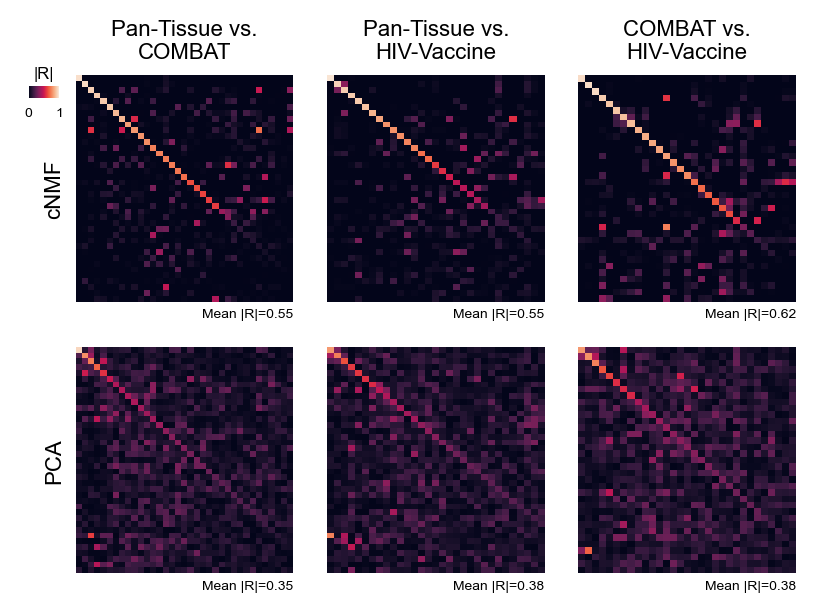

In [58]:
datasets = ['Pan-Tissue', 'COMBAT', 'HIV-Vaccine']

(fig,axes) = plt.subplots(2, 4, dpi=200, figsize=(4,3), gridspec_kw={'width_ratios':[.1,1,1,1], 'left':0, 'right':.97, 'bottom':.05})
cbar_ax = axes[0,0].inset_axes([0.4, .9, 1.4, 0.05], transform=axes[0,0].transAxes, )

for i in range(2):
    axes[i, 0].set_axis_off()

count = 0
for i in range(2):
    for j in range(i+1, 3):
        print(i,j)
        d1 = datasets[i]
        d2 = datasets[j]
        overlap = list(set(dataset_info[d1]['cNMF'].index).intersection(dataset_info[d2]['cNMF'].index))
        mapping, unmatched, R_cnmf = match_columns(dataset_info[d1]['cNMF'].loc[overlap, :], dataset_info[d2]['cNMF'].loc[overlap, :])

        if count < 2:
            sns.heatmap(R_cnmf.loc[list(mapping['X_columns']) + unmatched, list(mapping['Y_columns'])], ax=axes[0, count+1],
                    vmin=0, vmax=1, cbar=False, xticklabels=False, yticklabels=False)

        else:
            sns.heatmap(R_cnmf.loc[list(mapping['X_columns']) + unmatched, list(mapping['Y_columns'])], ax=axes[0, count+1],
                    vmin=0, vmax=1, cbar=True, xticklabels=False, yticklabels=False, 
                   cbar_ax=cbar_ax, cbar_kws={'orientation':'horizontal'})
        mean_R_cnmf = np.diagonal(R_cnmf.loc[list(mapping['X_columns']) + unmatched, 
                                             list(mapping['Y_columns'])]).mean()
        axes[0, count+1].text(x = .58, y = -0.07, s = 'Mean |R|=%.2f' % mean_R_cnmf, 
                              transform=axes[0, count+1].transAxes, fontsize = 5, color = 'black')

        mapping, unmatched, R_pca = match_columns_PCA(dataset_info[d1]['PCA'].loc[overlap, :], dataset_info[d2]['PCA'].loc[overlap, :])

        sns.heatmap(R_pca.loc[list(mapping['X_columns']) + unmatched, list(mapping['Y_columns'])], ax=axes[1, count+1],
                    vmin=0, vmax=1, cbar=False, xticklabels=False, yticklabels=False)
       
        mean_R_pca = np.diagonal(R_pca.loc[list(mapping['X_columns']) + unmatched, 
                                           list(mapping['Y_columns'])]).mean()
        axes[1, count+1].text(x = .58, y = -0.07, s = 'Mean |R|=%.2f' % mean_R_pca, 
                              transform=axes[1, count+1].transAxes, fontsize = 5, color = 'black')
        
        count += 1


for i,n in enumerate(['cNMF', 'PCA']):
    axes[i,1].set_ylabel(n, fontsize=8)

count = 0
for i in range(len(datasets)-1):    
    for j in range(i+1, len(datasets)):  
        n1 = datasets[i]
        n2 = datasets[j]
        axes[0, count+1].set_title('%s vs.\n%s' % (n1, n2), fontsize=8)
        count += 1

cbar_ax.tick_params(labelsize=5, length=0)
cbar_ax.set_title('|R|',fontsize=6, pad=3)
plt.savefig('../../Figures/Components/cNMF_Vs_PCA_Correlation_Heatmap.png')
plt.savefig('../../Figures/Components/cNMF_Vs_PCA_Correlation_Heatmap.pdf')
